### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline 
# %config InlineBackend.figure_format = 'retina' ## This is preferable for retina display. 

import warnings ## importing warnings library. 
warnings.filterwarnings('ignore') ## Ignore warning

### Load the data

In [2]:
DATA_PATH  = "./data/Survival_dataset.csv"

df = pd.read_csv(DATA_PATH)

We only keep the ``` Length_of_stay ``` feature as our target and drop the other targets (including ```recordid```). 

In [3]:
drop_cols = ["recordid", "SAPS-I", "SOFA", "Length_of_stay", "Survival"]
df = df.drop(columns = drop_cols)

Let's see some samples from the dataset.

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df.head()

,In-hospital_death,Age,Gender,Height,Weight,CCU,CSRU,SICU,DiasABP_first,GCS_first,Glucose_first,HR_first,MAP_first,NIDiasABP_first,NIMAP_first,NISysABP_first,RespRate_first,SaO2_first,Temp_first,DiasABP_last,GCS_last,Glucose_last,HR_last,MAP_last,NIDiasABP_last,NIMAP_last,NISysABP_last,RespRate_last,SaO2_last,Temp_last,DiasABP_lowest,GCS_lowest,Glucose_lowest,HR_lowest,MAP_lowest,NIDiasABP_lowest,NIMAP_lowest,NISysABP_lowest,RespRate_lowest,SaO2_lowest,Temp_lowest,DiasABP_highest,GCS_highest,Glucose_highest,HR_highest,MAP_highest,NIDiasABP_highest,NIMAP_highest,NISysABP_highest,RespRate_highest,SaO2_highest,Temp_highest,DiasABP_median,GCS_median,Glucose_median,HR_median,MAP_median,NIDiasABP_median,NIMAP_median,NISysABP_median,RespRate_median,SaO2_median,Temp_median,ALP_first,ALT_first,AST_first,Albumin_first,BUN_first,Bilirubin_first,Cholesterol_first,Creatinine_first,FiO2_first,HCO3_first,HCT_first,K_first,Lactate_first,Mg_first,Na_first,PaCO2_first,PaO2_first,Platelets_first,SysABP_first,TroponinI_first,TroponinT_first,WBC_first,Weight_first,pH_first,ALP_last,ALT_last,AST_last,Albumin_last,BUN_last,Bilirubin_last,Cholesterol_last,Creatinine_last,FiO2_last,HCO3_last,HCT_last,K_last,Lactate_last,Mg_last,Na_last,PaCO2_last,PaO2_last,Platelets_last,SysABP_last,TroponinI_last,TroponinT_last,WBC_last,Weight_last,pH_last,MechVentStartTime,MechVentDuration,MechVentLast8Hour,UrineOutputSum
0,0,54.0,0.0,NaN,NaN,0,0,1,NaN,15.0,205.0,73.0,NaN,65.0,92.33,147.0,19.0,NaN,35.1,NaN,15.0,115.0,86.0,NaN,55.0,79.33,128.0,23.0,NaN,37.8,NaN,14.0,115.0,58.0,NaN,39.0,58.67,96.0,12.0,NaN,35.1,NaN,15.0,205.0,86.0,NaN,67.0,92.33,157.0,24.0,NaN,38.2,NaN,15.0,160.0,73.0,NaN,49.0,70.000,110.0,18.0,NaN,37.70,NaN,NaN,NaN,NaN,13.0,NaN,NaN,0.8,NaN,26.0,33.7,4.4,NaN,1.5,137.0,NaN,NaN,221.0,NaN,NaN,NaN,11.2,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,0.7,NaN,28.0,30.3,4.0,NaN,1.9,136.0,NaN,NaN,185.0,NaN,NaN,NaN,9.4,NaN,NaN,NaN,NaN,NaN,NaN
1,0,76.0,1.0,175.3,76.0,0,1,0,67.0,3.0,105.0,88.0,79.0,38.0,49.33,72.0,NaN,99.0,35.2,51.0,15.0,146.0,65.0,69.0,49.0,68.33,107.0,NaN,97.0,37.1,32.0,3.0,105.0,65.0,43.0,38.0,49.33,72.0,NaN,93.0,34.5,81.0,15.0,146.0,90.0,100.0,67.0,88.33,131.0,NaN,99.0,37.9,59.0,15.0,125.5,80.0,79.0,59.0,78.165,115.0,NaN,97.0,37.45,NaN,NaN,NaN,NaN,16.0,NaN,NaN,0.8,1.0,21.0,24.7,4.3,NaN,3.1,139.0,34.0,344.0,164.0,105.0,NaN,NaN,7.4,80.6,7.45,NaN,NaN,NaN,NaN,21.0,NaN,NaN,1.3,0.4,24.0,29.4,3.5,NaN,1.9,135.0,46.0,140.0,135.0,103.0,NaN,NaN,13.3,81.6,7.37,71.0,360.0,0.0,5.0
2,0,44.0,0.0,NaN,56.7,0,0,0,81.0,7.0,141.0,100.0,107.0,84.0,100.30,133.0,NaN,95.0,37.8,70.0,5.0,143.0,71.0,92.0,84.0,103.00,141.0,NaN,95.0,37.2,52.0,5.0,119.0,57.0,72.0,66.0,83.33,111.0,NaN,95.0,36.7,81.0,8.0,143.0,113.0,107.0,95.0,110.00,150.0,NaN,95.0,39.0,67.0,5.0,141.0,85.5,90.0,79.0,97.670,134.0,NaN,95.0,37.85,127.0,91.0,235.0,2.7,8.0,3.0,NaN,0.4,1.0,24.0,28.5,3.3,1.3,1.9,137.0,37.0,65.0,72.0,148.0,NaN,NaN,4.2,56.7,7.51,105.0,75.0,164.0,2.3,3.0,2.8,NaN,0.3,0.4,25.0,29.4,3.7,0.9,1.7,138.0,37.0,173.0,113.0,126.0,NaN,NaN,6.2,56.7,7.47,617.0,2160.0,1.0,14.0
3,0,68.0,1.0,180.3,84.6,0,0,0,NaN,15.0,129.0,79.0,NaN,63.0,86.67,134.0,19.0,NaN,36.3,NaN,15.0,117.0,79.0,NaN,81.0,98.67,134.0,22.0,NaN,37.0,NaN,14.0,106.0,57.0,NaN,45.0,68.33,102.0,6.0,NaN,35.1,NaN,15.0,129.0,88.0,NaN,81.0,100.70,140.0,24.0,NaN,37.0,NaN,15.0,117.0,74.0,NaN,64.0,83.670,120.0,16.0,NaN,36.40,105.0,12.0,15.0,4.4,23.0,0.2,NaN,0.9,NaN,28.0,41.3,4.0,NaN,2.1,140.0,NaN,NaN,391.0,NaN,NaN,NaN,11.5,84.6,NaN,105.0,12.0,15.0,4.4,10.0,0.2,NaN,0.7,NaN,28.0,36.3,3.8,NaN,1.9,137.0,NaN,NaN,284.0,NaN,NaN,NaN,7.9,84.6,NaN,NaN,NaN,NaN,NaN
4,0,88.0,0.0,NaN,NaN,0,0,0,NaN,15.0,113.0,93.0,NaN,41.0,75.33,144.0,24.0,NaN,37.8,NaN,15.0,92.0,68.0,NaN,42.0,73.00,135.0,16.0,NaN,36.7,NaN,15.0,92.0,65.0,NaN,26.0,52.33,105.0,13.0,NaN,35.8,NaN,15.0,113.0,94.0,NaN,96.0,105.70,157.0,27.0,NaN,37.8,NaN,15.0,102.5,73.0,NaN,42.0,75.330,131.0,19.0,NaN,37.00,NaN,NaN,NaN,3.3,45.0,NaN,NaN,1.0,NaN,18.0,22.6,6.0,NaN,1.5,140.0,NaN,NaN,109.0,NaN,NaN,NaN,3.8,NaN,NaN,NaN,

### Column Manipulations

These are the columns:

In [6]:
gen_cols = ["Age", "Gender", "Height", "ICUType", "Weight"]

1. **Gender**: Apply One-hot encoding to ``` Gender ``` column

In [7]:
df["Gender_Female"] = (df["Gender"] == 0).astype(np.int64)
df["Gender_Male"] = (df["Gender"] == 1).astype(np.int64)
df = df.drop("Gender", axis = 1) 

2. **ICUType**:

We add the ``` ICUType_MICU ``` categorical column for the patient who were admissioned to a *MedicalICU*.

In [8]:
df["MICU"] = (~(df["CCU"].astype(bool) | df["CSRU"].astype(bool) | df["SICU"].astype(bool))).astype(np.int64)
df["ICUType"] = df[["CCU", "CSRU", "SICU", "MICU"]].idxmax(axis=1)
df.rename(columns={"CCU": "ICUType_CCU", "CSRU": "ICUType_CSRU", "MICU": "ICUType_MICU", "SICU" : "ICUType_SICU"}, 
          inplace = True)

df.groupby("ICUType").size()

ICUType
CCU      577
CSRU     874
MICU    1481
SICU    1068
dtype: int64

Let's sort the columns alphabetically

In [9]:
df = df.reindex(sorted(df.columns), axis=1)

### Time Series columns

In [10]:
time_series_cols = [x.split("_")[0] for x in df.columns if "first" in x] + ["MechVent"]
time_series_cols, len(time_series_cols)

(['ALP',
  'ALT',
  'AST',
  'Albumin',
  'BUN',
  'Bilirubin',
  'Cholesterol',
  'Creatinine',
  'DiasABP',
  'FiO2',
  'GCS',
  'Glucose',
  'HCO3',
  'HCT',
  'HR',
  'K',
  'Lactate',
  'MAP',
  'Mg',
  'NIDiasABP',
  'NIMAP',
  'NISysABP',
  'Na',
  'PaCO2',
  'PaO2',
  'Platelets',
  'RespRate',
  'SaO2',
  'SysABP',
  'Temp',
  'TroponinI',
  'TroponinT',
  'WBC',
  'Weight',
  'pH',
  'MechVent'],
 36)

### Train Test Split

In [11]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size = 0.2, shuffle = True, random_state = 42)

### Data Overview

In [12]:
train.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3200 entries, 3994 to 3174
Data columns (total 118 columns):
 #    Column             Non-Null Count  Dtype  
---   ------             --------------  -----  
 0    ALP_first          1359 non-null   float64
 1    ALP_last           1359 non-null   float64
 2    ALT_first          1377 non-null   float64
 3    ALT_last           1377 non-null   float64
 4    AST_first          1379 non-null   float64
 5    AST_last           1379 non-null   float64
 6    Age                3200 non-null   float64
 7    Albumin_first      1288 non-null   float64
 8    Albumin_last       1288 non-null   float64
 9    BUN_first          3144 non-null   float64
 10   BUN_last           3144 non-null   float64
 11   Bilirubin_first    1376 non-null   float64
 12   Bilirubin_last     1376 non-null   float64
 13   Cholesterol_first  261 non-null    float64
 14   Cholesterol_last   261 non-null    float64
 15   Creatinine_first   3144 non-null   float64
 16   C

In [13]:
test.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 555 to 2483
Data columns (total 118 columns):
 #    Column             Non-Null Count  Dtype  
---   ------             --------------  -----  
 0    ALP_first          331 non-null    float64
 1    ALP_last           331 non-null    float64
 2    ALT_first          344 non-null    float64
 3    ALT_last           344 non-null    float64
 4    AST_first          346 non-null    float64
 5    AST_last           346 non-null    float64
 6    Age                800 non-null    float64
 7    Albumin_first      327 non-null    float64
 8    Albumin_last       327 non-null    float64
 9    BUN_first          792 non-null    float64
 10   BUN_last           792 non-null    float64
 11   Bilirubin_first    342 non-null    float64
 12   Bilirubin_last     342 non-null    float64
 13   Cholesterol_first  44 non-null     float64
 14   Cholesterol_last   44 non-null     float64
 15   Creatinine_first   792 non-null    float64
 16   Cre

### Missing Value percentage per feature

Here are the percentages of missing values of each column in descending order.

In [14]:
def missing_percentage(df):
    """This function takes a DataFrame(df) as input and returns two columns, total missing values and total missing values percentage"""
    total = df.isnull().sum().sort_values(ascending = False)
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

In [15]:
missing_percentage(train)

,Total,Percent
TroponinI_last,3042,95.06
TroponinI_first,3042,95.06
Cholesterol_last,2939,91.84
Cholesterol_first,2939,91.84
TroponinT_first,2512,78.50
TroponinT_last,2512,78.50
RespRate_first,2327,72.72
RespRate_highest,2327,72.72
RespRate_last,2327,72.72
RespRate_lowest,2327,72.72


In [16]:
missing_percentage(test)

,Total,Percent
Cholesterol_last,756,94.50
Cholesterol_first,756,94.50
TroponinI_last,753,94.12
TroponinI_first,753,94.12
TroponinT_first,625,78.12
TroponinT_last,625,78.12
RespRate_first,572,71.50
RespRate_highest,572,71.50
RespRate_last,572,71.50
RespRate_lowest,572,71.50


### Data Visualisation

### Age per Survival

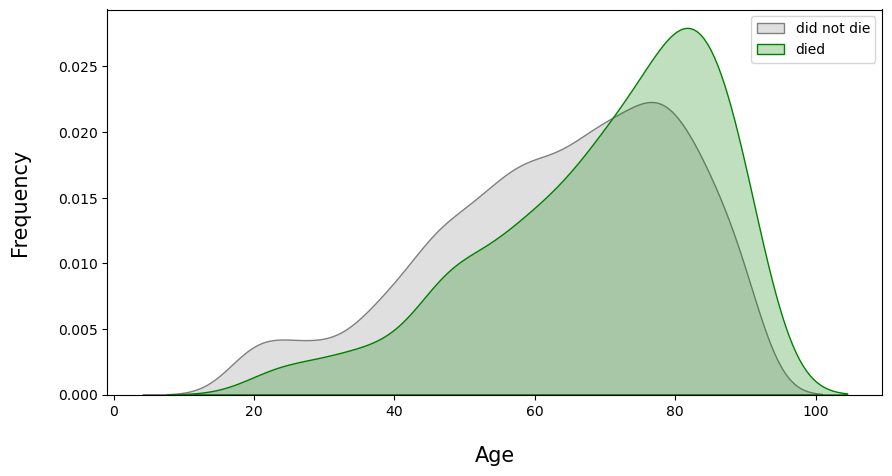

In [17]:
fig = plt.figure(figsize=(10,5),)
ax=sns.kdeplot(train.loc[(train['In-hospital_death'] == 0),'Age'] , color='gray',shade=True,label='did not die')
ax=sns.kdeplot(train.loc[(train['In-hospital_death'] == 1),'Age'] , color='g',shade=True, label='died')
plt.xlabel("Age", fontsize = 15, labelpad = 20)
plt.ylabel('Frequency', fontsize = 15, labelpad= 20)
plt.legend()
plt.show()

### Age per ICU Type

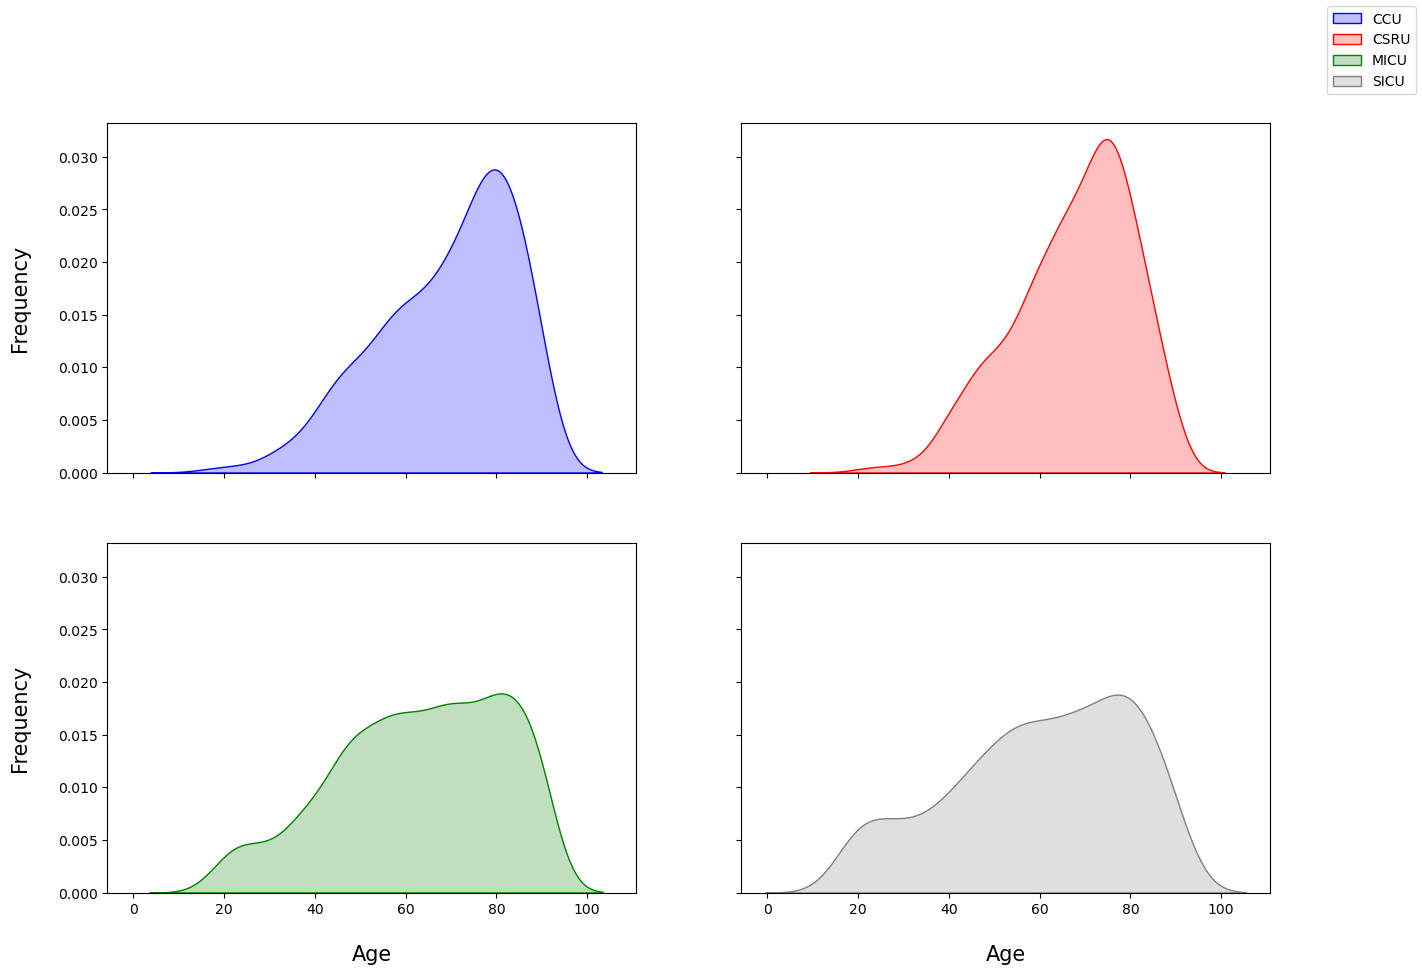

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(15,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.ravel()):
    c = ['b', 'r', 'g', 'grey'][i]
    icu = sorted(train['ICUType'].unique())[i]
    
    ax=sns.kdeplot(train.loc[(train['ICUType'] == icu),'Age'] , color=c,shade=True,label=icu, ax = ax)
    ax.set_xlabel("Age", fontsize = 15, labelpad = 20)
    ax.set_ylabel('Frequency', fontsize = 15, labelpad= 20)
    
fig.legend()
fig.show()

## Train Imputing

In [36]:
height = pd.read_csv("./data/height.csv")
height

,Sex,Year,Age group,Mean height,Mean height lower 95% uncertainty interval,Mean height upper 95% uncertainty interval,Mean height standard error
0,Boys,1985,5,105.649052,105.159635,106.172846,0.258115
1,Boys,1985,6,111.635352,111.190655,112.078230,0.227526
2,Boys,1985,7,117.189491,116.778453,117.595601,0.210784
3,Boys,1985,8,122.438103,122.054426,122.825657,0.199455
4,Boys,1985,9,127.499794,127.131517,127.885537,0.194522
5,Boys,1985,10,132.708099,132.348384,133.076987,0.187002
6,Boys,1985,11,137.851397,137.495601,138.226860,0.186425
7,Boys,1985,12,143.666854,143.301069,144.041974,0.191759
8,Boys,1985,13,150.399508,150.013085,150.788764,0.197735
9,Boys,1985,14,156.700319,156.296446,157.109215,0.206760


### Imputing Height based on Age and Gender

In [46]:
def get_height_cm(age, gender):
    height_data_cm = {
        1: (74,76), 
        2: (86,88), 
        3: (93,95), 
        4: (101,103), 
        5: (108,110), 
        6: (114,116), 
        7: (119,121), 
        8: (124,127), 
        9: (130,132), 
        10: (135,137), 
        11: (142,143), 
        12: (147,150), 
        13: (151,156), 
        14: (157,163), 
        15: (160,169), 
        16: (162,173), 
        18: (164,177), 
        39: (164,176),
        59: (163,175),
        80: (161,173)
    }

    return (height_data_cm.get(age) or height_data_cm[
        min(height_data_cm.keys(), key = lambda key: abs(age - key))])[gender]

get_height_cm(62,1)

175

### Imputing Wei

## NB without preprocessing

In [ ]:
df["MICU"] = (~(df["CCU"].astype(bool) | df["CSRU"].astype(bool) | df["SICU"].astype(bool))).astype(np.int64)
df["ICUType"] = df[["CCU", "CSRU", "SICU", "MICU"]].idxmax(axis=1)
df["ICUType"] = (df["ICUType"] == "CSRU") * 1 + (df["ICUType"] == "MICU") * 2 + (df["ICUType"] == "SICU") * 3
X, y = df.drop(columns = ["In-hospital_death"]), df["In-hospital_death"]

In [ ]:
class SurvivalNB:
    def __init__(self, alpha = 1):
        self.priors = None
        self.cont_mean = None
        self.cont_var = None
        self.gender_prob = None
        self.icu_prob = None
        
        self.alpha = alpha
    
    def fit(self, X, y):
        self.priors = np.zeros(2)

        self.cont_mean = np.zeros((2, X.shape[1] - 2))        
        self.cont_var = np.zeros((2, X.shape[1] - 2))
        self.gender_prob = np.zeros((2, 2))
        self.icu_prob = np.zeros((2 , 4))
        
        for i in range(2):
            X_class = X.loc[(y == i), :]
            
            self.priors[i] = np.sum(y == i) / len(y)
            
            gender_counts = X_class.groupby("Gender")["Gender"].count()
            self.gender_prob[i, :] = (gender_counts + self.alpha) / (X["Gender"].count() + 2 * self.alpha)
            
            icu_counts = X_class.groupby("ICUType")["ICUType"].count()
            self.icu_prob[i, :] = (icu_counts + self.alpha) / (X["ICUType"].count() + 4 * self.alpha)
        
            X_class_cont = X_class.drop(columns = ["Gender", "ICUType"])
            self.cont_mean[i, :] = np.sum(X_class_cont, axis=0) / X_class_cont.count()
            self.cont_var[i, :] = np.var(X_class_cont, axis=0)
            
            
    
    def predict(self, X):
        pred = [self._predict(X.iloc[i, :]) for i in range(len(X))]
        return np.array(pred)
    
    def _predict(self, x):
        posteriors = np.zeros(2)
        
        for i in range(2):
            posteriors[i] = self.priors[i]
            posteriors[i] *= self.gender_prob[i, x["Gender"]]
            posteriors[i] *= self.icu_prob[i, x["ICUType"]]
            
            posteriors[i] *= np.prod(self._gaussian_pdf(x, i))
        
        return np.argmax(posteriors)
    
    def _gaussian_pdf(self, x, i):
        x_cont = x.drop(["Gender", "ICUType"])
        
        mean = self.cont_mean[i]
        var = self.cont_var[i]
        
        numerator = np.exp(-(x_cont - mean) ** 2 / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        
        return numerator / denominator       
            
        
        
        

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, auc, roc_curve, matthews_corrcoef

def print_metrics(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)    

    print(f"Confusion Matrix")
    print(f"{conf_matrix}\n")
    print(f"Accuracy: {(tp + tn)/(tp + tn + fn + fp)}")
    print(f"Precision: {tp / (tp + fp)}")
    print(f"Recall: {tp / (tp + fn)}")
    print(f"AUC score: {auc(fpr, tpr)}")
    print(f"MCC score: {mcc}")
    print(f"F1-Score: {(tp)/(tp+(fp+fn)/2)}\n")

In [ ]:
from sklearn.model_selection import KFold

nb = SurvivalNB()
kf = KFold(n_splits=20, shuffle=True, random_state=42)
scores = np.zeros(kf.get_n_splits(X))

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, y_train= X.iloc[train_index, :], y[train_index]
    X_test, y_test = X.iloc[test_index, :], y[test_index]
    
    nb.fit(X_train, y_train)
    y_train_pred = nb.predict(X_train)
    y_test_pred = nb.predict(X_test)
    
    print("Train Set Results: ")
    print_metrics(y_train, y_train_pred)

    print("Test Set Results: ")
    print_metrics(y_test, y_test_pred)
    
np.mean(scores)

In [ ]:
X.iloc[i, :]["ICUType"]

In [5]:
list(df.columns)

['In-hospital_death',
 'Age',
 'Gender',
 'Height',
 'Weight',
 'CCU',
 'CSRU',
 'SICU',
 'DiasABP_first',
 'GCS_first',
 'Glucose_first',
 'HR_first',
 'MAP_first',
 'NIDiasABP_first',
 'NIMAP_first',
 'NISysABP_first',
 'RespRate_first',
 'SaO2_first',
 'Temp_first',
 'DiasABP_last',
 'GCS_last',
 'Glucose_last',
 'HR_last',
 'MAP_last',
 'NIDiasABP_last',
 'NIMAP_last',
 'NISysABP_last',
 'RespRate_last',
 'SaO2_last',
 'Temp_last',
 'DiasABP_lowest',
 'GCS_lowest',
 'Glucose_lowest',
 'HR_lowest',
 'MAP_lowest',
 'NIDiasABP_lowest',
 'NIMAP_lowest',
 'NISysABP_lowest',
 'RespRate_lowest',
 'SaO2_lowest',
 'Temp_lowest',
 'DiasABP_highest',
 'GCS_highest',
 'Glucose_highest',
 'HR_highest',
 'MAP_highest',
 'NIDiasABP_highest',
 'NIMAP_highest',
 'NISysABP_highest',
 'RespRate_highest',
 'SaO2_highest',
 'Temp_highest',
 'DiasABP_median',
 'GCS_median',
 'Glucose_median',
 'HR_median',
 'MAP_median',
 'NIDiasABP_median',
 'NIMAP_median',
 'NISysABP_median',
 'RespRate_median',
 'SaO

In [8]:
print("Hi "
      "sdas")

Hi sdas
